In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from SRGAN_funcs.data_utils import load_and_combine_channels
from SRGAN_funcs.physics import compute_grid_spacing

In [30]:
@tf.function  # Ensures compatibility with Graph Mode
def gradient_fd(sr, channel, dx, dy):
    """
    Computes the gradient of a specific channel (velocity or SSH) using finite differences.

    Args:
    - sr: tf.Tensor of shape (batch, height, width, 3), where:
          sr[..., 0] = u_x (zonal velocity),
          sr[..., 1] = u_y (meridional velocity),
          sr[..., 2] = SSH (η).
    - dx: tf.Tensor of shape (height, width - 1), grid spacing in x.
    - dy: tf.Tensor of shape (height - 1, width), grid spacing in y.
    - channel: Index of the channel to compute the gradient for (0 for u_x, 1 for u_y, 2 for SSH).

    Returns:
    - grad_x, grad_y: Gradients of the selected channel in x and y directions.
    """

    if isinstance(dx, tf.Tensor) and dx.shape.ndims == 4:
        dx = tf.squeeze(dx, axis=[0, -1])  # [H, W]
        dy = tf.squeeze(dy, axis=[0, -1])
    
    var = sr[..., channel]  # Shape: (batch, height, width)
    # Compute gradient along x using central difference
    x_minus = tf.slice(var, [0, 0, 0], [-1, -1, tf.shape(var)[-1] - 2])
    x_plus = tf.slice(var, [0, 0, 2], [-1, -1, tf.shape(var)[-1] - 2])
    grad_x = (x_plus - x_minus)
    grad_x = tf.concat([grad_x[:, :, :1], grad_x, grad_x[:, :, -1:]], axis=2)  # Restore original shape
    grad_x /= (2 * dx[None, :, :])

    # Compute gradient along y using central difference
    y_minus = tf.slice(var, [0, 0, 0], [-1, tf.shape(var)[1] - 2, -1])
    y_plus = tf.slice(var, [0, 2, 0], [-1, tf.shape(var)[1] - 2, -1])
    grad_y = (y_plus - y_minus)
    grad_y = tf.concat([grad_y[:, :1, :], grad_y, grad_y[:, -1:, :]], axis=1)  # Restore original shape
    grad_y /= (2 * dy[None, :, :])
    
    grad = tf.stack([grad_x, grad_y], axis=-1)
    
    return grad

def gaussian_kernel1d(size, sigma, order=0):
    if order < 0:
        raise ValueError("order must be non-negative")

    x = np.arange(-size // 2 + 1, size // 2 + 1)
    sigma2 = sigma ** 2

    if order == 0:
        kernel = np.exp(-0.5 * (x ** 2) / sigma2)
        kernel /= kernel.sum()
    elif order == 1:
        kernel = -x * np.exp(-0.5 * (x ** 2) / sigma2)
        kernel /= np.sum(x * kernel)
    elif order == 2:
        kernel = (x ** 2 - sigma2) * np.exp(-0.5 * (x ** 2) / sigma2)
        kernel /= np.sum(0.5 * (x ** 2) * kernel)
    else:
        raise NotImplementedError("Higher-order derivatives not implemented")

    return tf.convert_to_tensor(kernel, dtype=tf.float32)

def gaussian_gradient(image, size=5, sigma=1.0, dx=1.0, dy=1.0):

    image = tf.convert_to_tensor(image)

    if len(image.shape) == 2:
        image = tf.expand_dims(tf.expand_dims(image, axis=0), axis=-1)
    elif len(image.shape) == 3:
        if image.shape[-1] != 1:  # sospechoso, podría ser (B, H, W) sin canal
            image = tf.expand_dims(image, axis=-1)
    elif len(image.shape) == 4 and image.shape[-1] != 1:
        raise ValueError(f"Expected single-channel input, got shape {image.shape}")

    pad = size // 2

    # Separate padding for each direction
    image_pad_x = tf.pad(image, [[0, 0], [0, 0], [pad, pad], [0, 0]], mode='SYMMETRIC')  # pad width
    image_pad_y = tf.pad(image, [[0, 0], [pad, pad], [0, 0], [0, 0]], mode='SYMMETRIC')  # pad height

    kernel_x = gaussian_kernel1d(size, sigma, 1)
    kernel_y = gaussian_kernel1d(size, sigma, 1)

    kernel_x = tf.reshape(kernel_x, [1, size, 1, 1])  # horizontal
    kernel_y = tf.reshape(kernel_y, [size, 1, 1, 1])  # vertical

    grad_x = tf.nn.conv2d(image_pad_x, kernel_x, strides=[1, 1, 1, 1], padding="VALID")
    grad_y = tf.nn.conv2d(image_pad_y, kernel_y, strides=[1, 1, 1, 1], padding="VALID")
    
    grad_x = grad_x/dx
    grad_y = grad_y/dy
    
    return tf.concat([grad_x, grad_y], axis=-1)

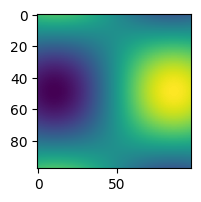

In [31]:
x = tf.linspace(-2.0, 2.0, 98)
y = tf.linspace(-2.0, 2.0, 98)
X, Y = tf.meshgrid(x, y)
ssh = tf.sin(X) * tf.cos(Y)
dssh_dx = tf.cos(X) * tf.cos(Y)
dssh_dy = -tf.sin(X) * tf.sin(Y)
sr = tf.stack([ssh, ssh, ssh], axis=-1)[None, ...]  # (1, H, W, 3)

plt.figure(figsize=(2, 2))
plt.imshow(ssh)

Mean absolute error TF (dx): 0.012077426
Mean absolute error TF (dy): 0.023529837
Mean absolute error scipy (dx): 0.011509565
Mean absolute error scipy (dy): 0.021834444


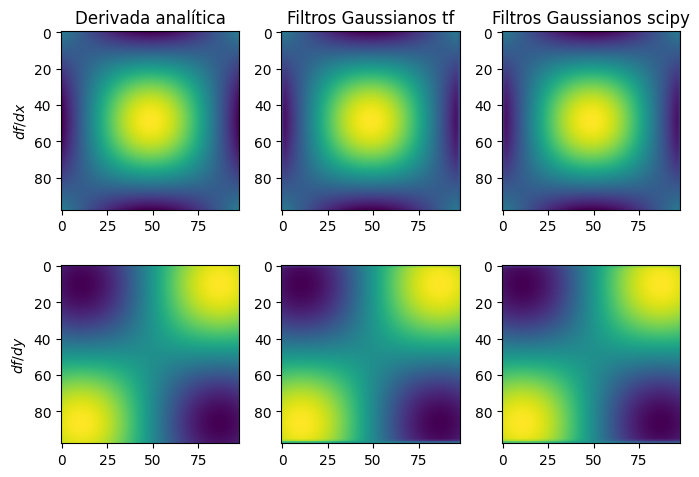

In [32]:
fig, ax = plt.subplots(2, 3, figsize=(7, 5))

ax[0, 0].imshow(dssh_dx)
ax[0, 0].set_title("Derivada analítica")
ax[0, 0].set_ylabel(r"$df/dx$")
ax[1, 0].imshow(dssh_dy)
ax[1, 0].set_ylabel(r"$df/dy$")

gauss_grad = gaussian_gradient(ssh, size=5, sigma=1.0, dx=0.04, dy=0.04)
dx = gauss_grad[..., 0]
dy = gauss_grad[..., 1]

# Compare dx to analytical: tf.cos(X) * tf.cos(Y)
error = tf.reduce_mean(tf.abs(dx[0] - dssh_dx))
print("Mean absolute error TF (dx):", error.numpy())
error = tf.reduce_mean(tf.abs(dy[0] - dssh_dy))
print("Mean absolute error TF (dy):", error.numpy())

ax[0, 1].imshow(dx[0])
ax[0, 1].set_title("Filtros Gaussianos tf")
ax[1, 1].imshow(dy[0])

from scipy.ndimage import gaussian_filter1d

sigma = 1
dx = dy = 0.04
ssh_dx = gaussian_filter1d(ssh, sigma=sigma, order=1, axis=1, mode='nearest') / dx
ssh_dy = gaussian_filter1d(ssh, sigma=sigma, order=1, axis=0, mode='nearest') / dy

# Compare dx to analytical: tf.cos(X) * tf.cos(Y)
error = tf.reduce_mean(tf.abs(ssh_dx - dssh_dx))
print("Mean absolute error scipy (dx):", error.numpy())
error = tf.reduce_mean(tf.abs(ssh_dy - dssh_dy))
print("Mean absolute error scipy (dy):", error.numpy())

ax[0, 2].imshow(ssh_dx)
ax[0, 2].set_title("Filtros Gaussianos scipy")
ax[1, 2].imshow(ssh_dy)

plt.tight_layout()

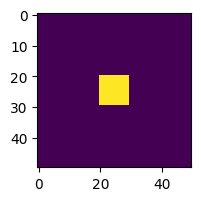

In [33]:
# Image size
n = 50
image = tf.zeros((n, n), dtype=tf.float32)

# Define square region (e.g., 20x20 in the center)
square_size = 10
start = (n - square_size) // 2
end = start + square_size

# Create the indices for the square
xx, yy = tf.meshgrid(tf.range(start, end), tf.range(start, end), indexing='ij')
indices = tf.stack([xx, yy], axis=-1)
indices = tf.reshape(indices, [-1, 2])

# Create updates (all ones for the square region)
updates = tf.ones((square_size * square_size,), dtype=tf.float32)

# Update image
image = tf.tensor_scatter_nd_update(image, indices, updates)

plt.figure(figsize=(2, 2))
plt.imshow(image)

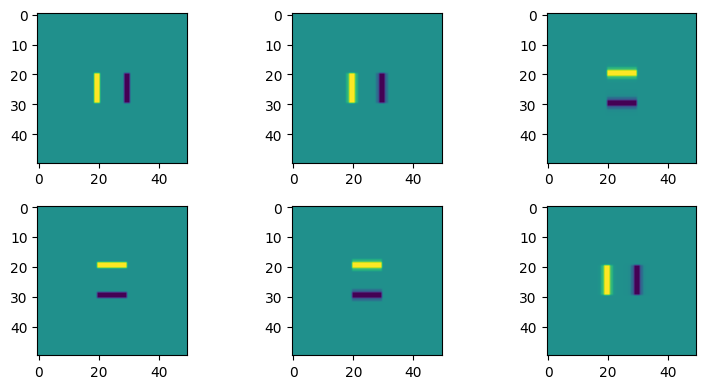

In [34]:
image = tf.reshape(image, [1, n, n, 1])

x = tf.linspace(-2.0, 2.0, n)
y = tf.linspace(-2.0, 2.0, n)
X, Y = tf.meshgrid(x, y)

dx = tf.ones_like(X) * 0.04
dy = tf.ones_like(Y) * 0.04

grad_fd = gradient_fd(image, 0, dx, dy)

dx_fd = grad_fd[..., 0]
dy_fd = grad_fd[..., 1]

grad_gf = gaussian_gradient(image)
dx_gf, dy_gf = grad_gf[..., 0], grad_gf[..., 1]
dx_gf /= 0.04
dy_gf /= 0.04

dx_scipy = gaussian_filter1d(image, sigma=sigma, order=1, axis=1, mode='nearest') / 0.04
dy_scipy = gaussian_filter1d(image, sigma=sigma, order=1, axis=2, mode='nearest') / 0.04

dx_scipy = tf.reshape(dx_scipy, [n, n])
dy_scipy = tf.reshape(dy_scipy, [n, n])

fig, ax = plt.subplots(2, 3, figsize=(8, 4))
ax[0, 0].imshow(dx_fd[0])
ax[1, 0].imshow(dy_fd[0])
ax[0, 1].imshow(dx_gf[0])
ax[1, 1].imshow(dy_gf[0])
ax[0, 2].imshow(dx_scipy)
ax[1, 2].imshow(dy_scipy)
plt.tight_layout()

In [52]:
train_hr_folder = os.path.join(os.getcwd(), "../../data", "val", "HR")
hr_images = load_and_combine_channels(train_hr_folder, 'ssh')
shuffled = tf.random.shuffle(hr_images)
# Select first 5
hr_images = shuffled[:5][..., -1]
hr_images = tf.reshape(hr_images, [5, 64, 64, 1])

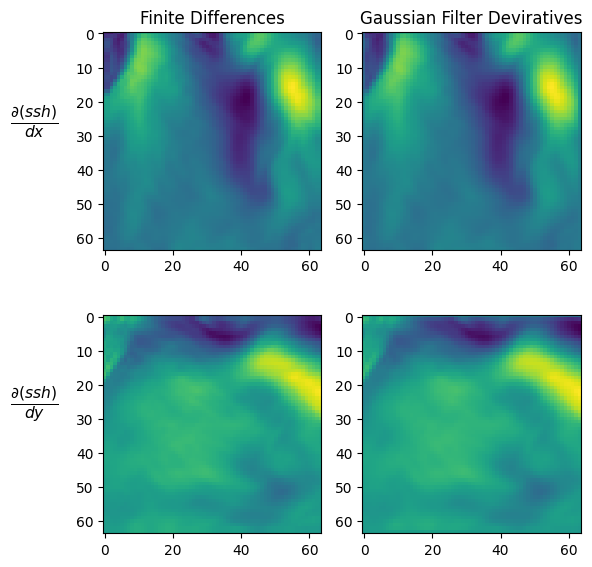

In [53]:
dx, dy, _ = compute_grid_spacing(True)

grad_fd = gradient_fd(hr_images, 0, dx, dy)
dx_fd = grad_fd[..., 0]
dy_fd = grad_fd[..., 1]

grad_gf = gaussian_gradient(hr_images, 5, 1, dx, dy)
dx_gf, dy_gf = grad_gf[..., 0], grad_gf[..., 1]


fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0, 0].imshow(dx_fd[0])
ax[1, 0].imshow(dy_fd[0])
ax[0, 1].imshow(dx_gf[0])
ax[1, 1].imshow(dy_gf[0])

ax[0, 0].set_ylabel(r'$\frac{\partial(ssh)}{dx}$', rotation=0, fontsize=16, labelpad=30)
ax[1, 0].set_ylabel(r'$\frac{\partial(ssh)}{dy}$', rotation=0, fontsize=16, labelpad=30)
ax[0, 0].set_title("Finite Differences")
ax[0, 1].set_title("Gaussian Filter Deviratives")
plt.tight_layout()